In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")
import copy
import os
import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
# from src.data import load_relation
import json

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+5)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

def plot_patch_blocking_results(
    patch_recovery,
    ssm_severed,
    non_ssm_severed,
):
    state_indirect_effects = {
        "Recovery": patch_recovery,
        "SSM Severed": ssm_severed,
        "Non-SSM Severed": non_ssm_severed,
    }
    config_color = {
        "Recovery": "blue",
        "SSM Severed": "red",
        "Non-SSM Severed": "green",
    }

    # plt.rcdefaults()
    plt.figure(figsize=(20, 6))
    n_layer = len(patch_recovery)

    idx = 0
    bar_width = 0.25
    for config in state_indirect_effects:
        plot_ie = []
        for layer in range(n_layer):
            plot_ie.append(state_indirect_effects[config][layer])
        
        plt.bar(
            np.arange(len(plot_ie)) + idx * bar_width, plot_ie,
            width = bar_width,
            label = config,
            # edgecolor = "black",
            color = config_color[config],
            alpha = 0.9
        )
        idx += 1

    def layer_tick(layer_idx, jump=5):
        return f"{layer_idx}" if layer_idx % jump == 0 else ""

    plt.ylim(0, 1)
    plt.xticks(
        np.arange(len(patch_recovery)) + bar_width, 
        [layer_tick(i) for i in range(n_layer)]
    )
    
    ylabel = f"Indirect Effect ({'%'} of p(ans) recovered)"

    plt.ylabel(ylabel)
    plt.legend(ncol = 3, bbox_to_anchor=(0.5, -.18), loc='lower center', frameon=False)
    # plt.savefig(f"figs/faithfulness_lre_models.pdf", bbox_inches="tight")
    plt.show()


2024-03-22 14:09:46 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data
2024-03-22 14:09:46 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-03-22 14:09:46 matplotlib DEBUG    interactive is False
2024-03-22 14:09:46 matplotlib DEBUG    platform is linux
2024-03-22 14:09:46 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-03-22 14:09:46 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json


In [10]:
RESULTS_DIR = os.path.join("../../", "results")
path_blocking_dir = os.path.join(RESULTS_DIR, "ablation")

relations = os.listdir(path_blocking_dir)
relations

['person_occupation',
 'landmark_in_country',
 'company_ceo',
 'country_capital_city',
 'company_hq',
 'place_in_city',
 'person_plays_pro_sport',
 'product_by_company']

In [11]:
at_token = "prompt_last"
# at_token = "subject_last"

patch_recovery_all = []
ssm_severed_all = []
non_ssm_severed_all = []
for relation in relations:
    results_file = os.path.join(path_blocking_dir, relation, f"{at_token}.json")
    try:
        with open(results_file, "r") as f:
            ablation_results = json.load(f)
    except FileNotFoundError:
        print(f"File not found: {results_file} -- skipping...")
        continue
    print(f"{relation}...{len(ablation_results['trials'])} trials.")
    patch_recovery_all += [trial["patch_recovery"] for trial in ablation_results["trials"]]
    ssm_severed_all += [trial["ssm_severed"] for trial in ablation_results["trials"]]
    non_ssm_severed_all += [trial["mlp_severed"] for trial in ablation_results["trials"]]    

len(patch_recovery_all)

person_occupation...51 trials.
landmark_in_country...150 trials.
File not found: ../../results/ablation/company_ceo/prompt_last.json -- skipping...
country_capital_city...16 trials.
company_hq...150 trials.
place_in_city...97 trials.
person_plays_pro_sport...150 trials.
product_by_company...150 trials.


764

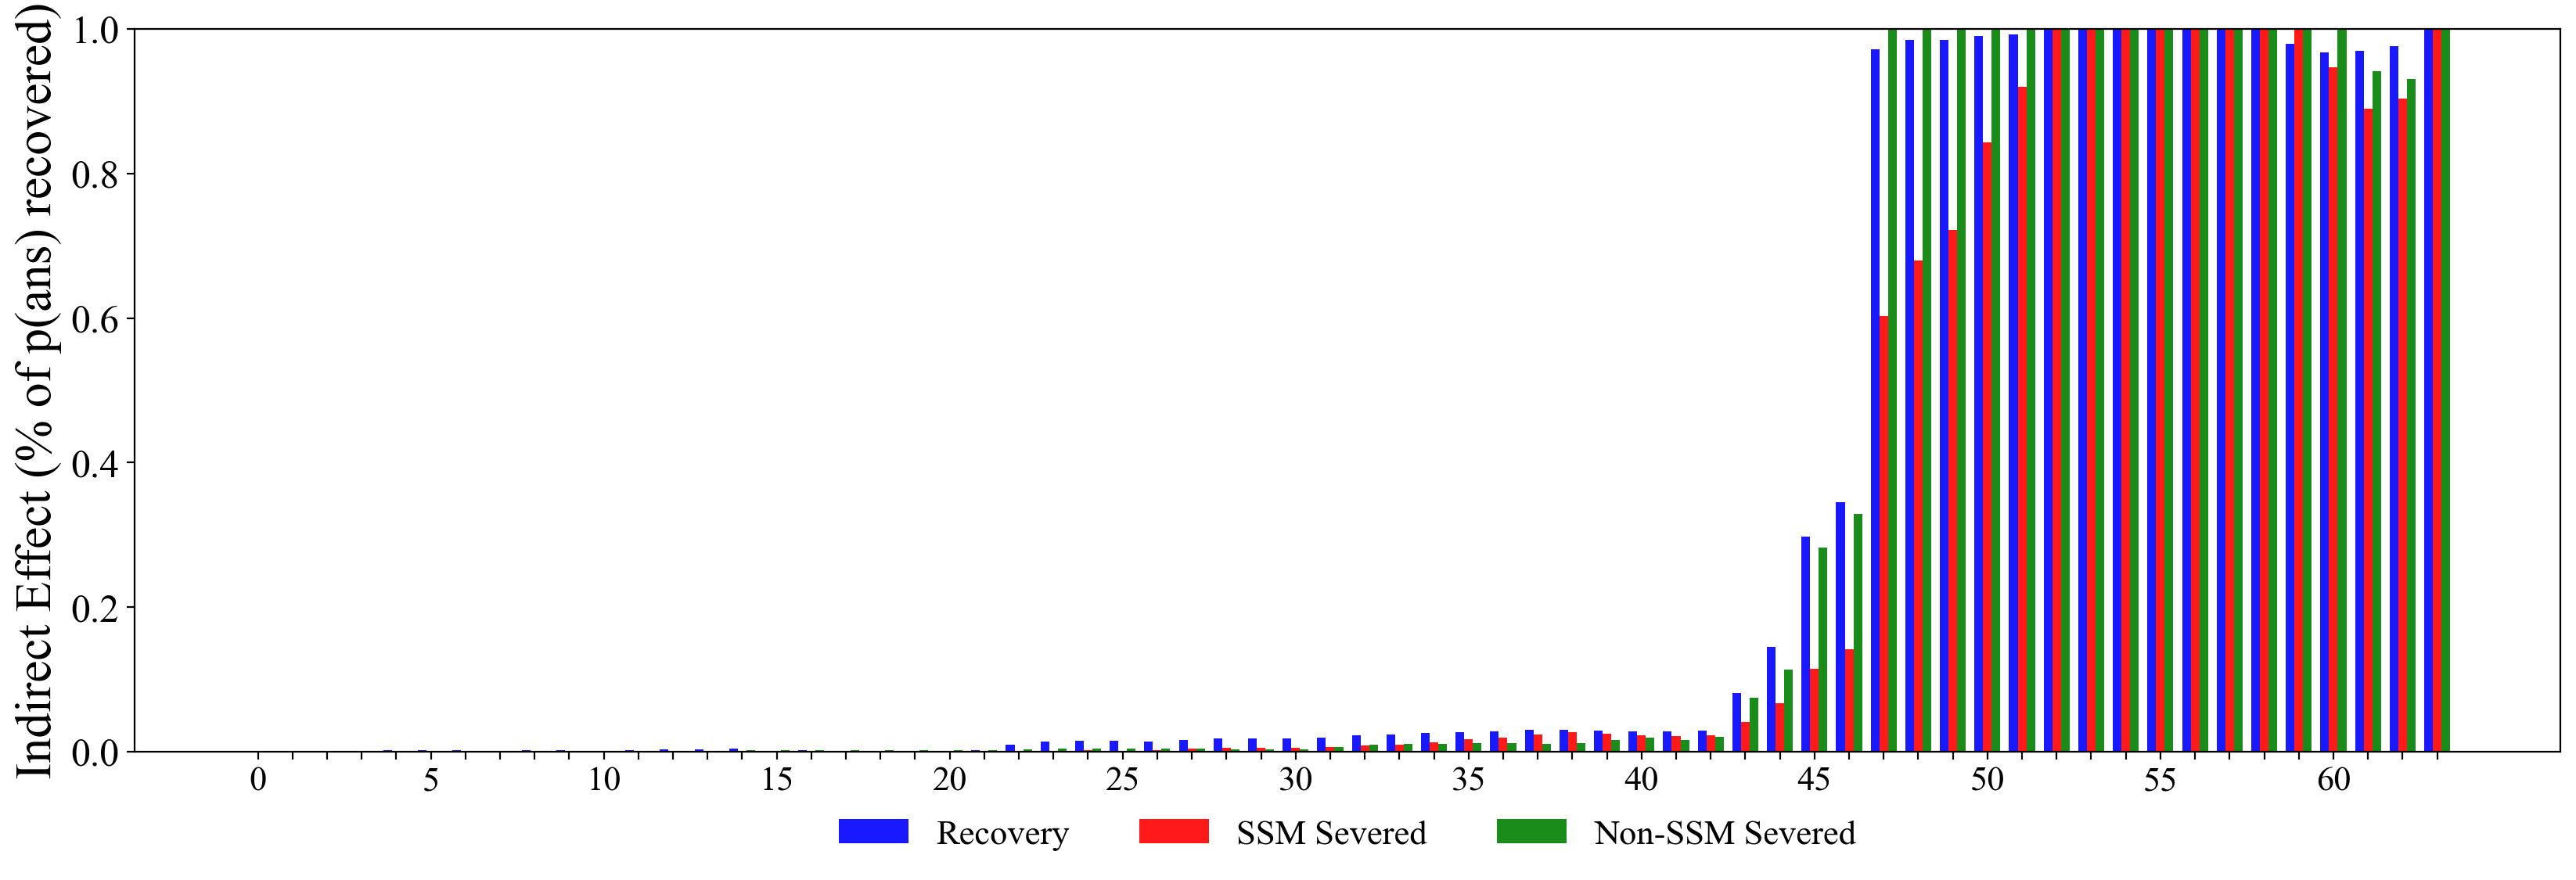

In [12]:
import torch
patch_recovery_avg = torch.Tensor(patch_recovery_all).mean(dim=0).squeeze().numpy()
ssm_severed_avg = torch.Tensor(ssm_severed_all).mean(dim=0).squeeze().numpy()
non_ssm_severed_avg = torch.Tensor(non_ssm_severed_all).mean(dim=0).squeeze().numpy()

plot_patch_blocking_results(
    patch_recovery_avg,
    ssm_severed_avg,
    non_ssm_severed_avg,
)